# Falcon 9 Landing Prediction
## Step 2: Data Wrangling & Cleaning

**Objective:** Prepare the Falcon 9 launch dataset for analysis and modeling by inspecting data quality, handling missing values, and selecting usable records.


In [1]:
import pandas as pd

from pathlib import Path

data_path = Path("data") / "falcon9_step1_api_data.csv"

df = pd.read_csv(data_path)
df.shape

(179, 15)

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   name             179 non-null    object
 1   date_utc         179 non-null    object
 2   success          178 non-null    object
 3   cores            179 non-null    object
 4   rocket           179 non-null    object
 5   payloads         179 non-null    object
 6   launchpad        179 non-null    object
 7   core_flight      179 non-null    int64 
 8   core_reused      179 non-null    bool  
 9   landing_attempt  179 non-null    bool  
 10  landing_success  153 non-null    object
 11  landing_type     155 non-null    object
 12  landpad          148 non-null    object
 13  rocket_name      179 non-null    object
 14  Class            179 non-null    int64 
dtypes: bool(2), int64(2), object(11)
memory usage: 10.9+ KB


In [3]:
df.isna().sum()

name                0
date_utc            0
success             1
cores               0
rocket              0
payloads            0
launchpad           0
core_flight         0
core_reused         0
landing_attempt     0
landing_success    26
landing_type       24
landpad            31
rocket_name         0
Class               0
dtype: int64

In [4]:
df_attempts = df[df["landing_attempt"] == True].copy()

df_attempts.shape


(155, 15)

In [5]:
df_attempts_clean = df_attempts.dropna(subset=["landing_success"]).copy()

df_attempts_clean.shape


(153, 15)

In [6]:
model_df = df_attempts_clean[
    [
        "core_flight",
        "core_reused",
        "landing_type",
        "landpad",
        "Class"
    ]
].copy()

model_df.head()


,core_flight,core_reused,landing_type,landpad,Class
5,1,False,Ocean,NaN,0
8,1,False,Ocean,NaN,1
9,1,False,Ocean,NaN,1
12,1,False,Ocean,NaN,0
13,1,False,ASDS,5e9e3032383ecb761634e7cb,0


In [7]:
from pathlib import Path

data_dir = Path("data")
data_dir.mkdir(exist_ok=True)

model_df.to_csv(data_dir / "falcon9_step2_cleaned.csv", index=False)


## Step 2 Summary – Data Wrangling & Cleaning

In this step, I prepared the Falcon 9 dataset for modeling by applying defensible data-cleaning decisions.

Key actions:
- Loaded the API-derived dataset from Step 1
- Identified and interpreted missing values rather than blindly imputing
- Filtered launches to those with a landing attempt
- Removed rows with unknown landing outcomes
- Selected a focused set of modeling features
- Preserved rare but valid edge cases for later handling

**Output dataset:**  
`data/falcon9_step2_cleaned.csv`


# Step 3: Exploratory Data Analysis (EDA)

**Objective:** Explore patterns and relationships in Falcon 9 landing data to understand which factors influence landing success.


In [8]:
from pathlib import Path
import pandas as pd

data_path = Path("data") / "falcon9_step2_cleaned.csv"
eda_df = pd.read_csv(data_path)

eda_df.shape


(153, 5)

<Axes: title={'center': 'Landing Success Rate by Booster Reuse'}, xlabel='Booster Reused', ylabel='Success Rate'>

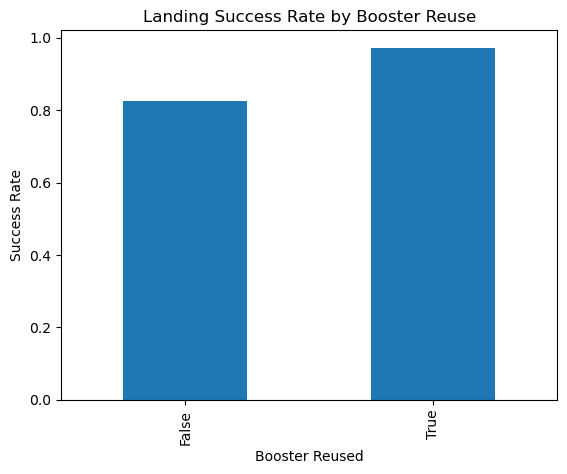

In [9]:
eda_df.groupby("core_reused")["Class"].mean().plot(
    kind="bar",
    title="Landing Success Rate by Booster Reuse",
    ylabel="Success Rate",
    xlabel="Booster Reused"
)


<Axes: title={'center': 'Landing Success Rate vs Booster Flight Number'}, xlabel='Booster Flight Number', ylabel='Success Rate'>

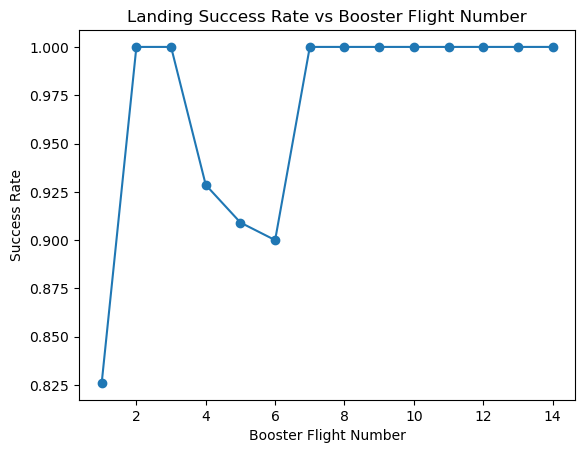

In [10]:
eda_df.groupby("core_flight")["Class"].mean().plot(
    kind="line",
    marker="o",
    title="Landing Success Rate vs Booster Flight Number",
    xlabel="Booster Flight Number",
    ylabel="Success Rate"
)


In [11]:
eda_df.groupby("landing_type")["Class"].mean()


landing_type
ASDS     0.934426
Ocean    0.714286
RTLS     0.958333
Name: Class, dtype: float64

<Axes: title={'center': 'Landing Success Rate by Landing Type'}, xlabel='Landing Type', ylabel='Success Rate'>

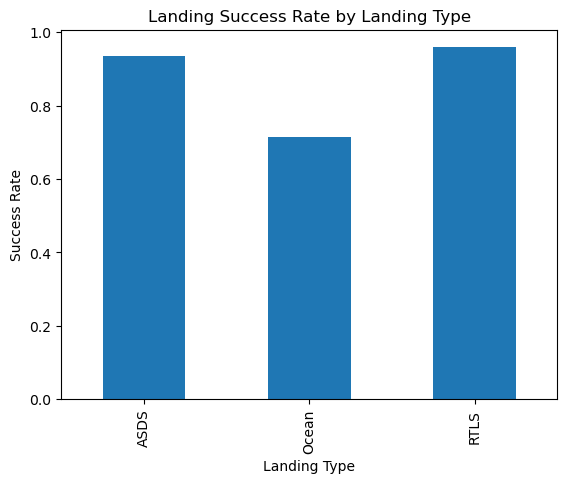

In [12]:
eda_df.groupby("landing_type")["Class"].mean().plot(
    kind="bar",
    title="Landing Success Rate by Landing Type",
    ylabel="Success Rate",
    xlabel="Landing Type"
)


## Step 3 Summary – Exploratory Data Analysis

Key observations from the Falcon 9 landing data:

- Reused boosters show a slightly higher landing success rate than new boosters
- Landing success does not strongly increase with booster flight number and appears generally flat
- RTLS (Return to Launch Site) landings have a higher success rate than ASDS (droneship) landings
- Early-flight success rates appear inflated due to careful mission selection and smaller sample sizes

These findings suggest that landing success is influenced by multiple interacting factors rather than a single dominant variable.


# Step 4: Feature Encoding & Preparation

**Objective:** Transform cleaned features into a numerical format suitable for machine learning models and prepare training and testing datasets.


In [13]:
import pandas as pd
from pathlib import Path

data_path = Path("data") / "falcon9_step2_cleaned.csv"

df = pd.read_csv(data_path)

df.head()


,core_flight,core_reused,landing_type,landpad,Class
0,1,False,Ocean,NaN,0
1,1,False,Ocean,NaN,1
2,1,False,Ocean,NaN,1
3,1,False,Ocean,NaN,0
4,1,False,ASDS,5e9e3032383ecb761634e7cb,0


In [14]:
landing_type_dummies = pd.get_dummies(
    df["landing_type"],
    prefix="landing_type"
)

landing_type_dummies.head()


,landing_type_ASDS,landing_type_Ocean,landing_type_RTLS
0,False,True,False
1,False,True,False
2,False,True,False
3,False,True,False
4,True,False,False


In [15]:
df["landpad_filled"] = df["landpad"].fillna("Unknown")

landpad_dummies = pd.get_dummies(df["landpad_filled"], prefix="landpad")

landpad_dummies.head()


,landpad_5e9e3032383ecb267a34e7c7,landpad_5e9e3032383ecb554034e7c9,landpad_5e9e3032383ecb6bb234e7ca,landpad_5e9e3032383ecb761634e7cb,landpad_5e9e3033383ecb075134e7cd,landpad_5e9e3033383ecbb9e534e7cc,landpad_Unknown
0,False,False,False,False,False,False,True
1,False,False,False,False,False,False,True
2,False,False,False,False,False,False,True
3,False,False,False,False,False,False,True
4,False,False,False,True,False,False,False


In [16]:
# Numeric features
numeric_features = df[["core_flight", "core_reused"]]

# Combine all features
X = pd.concat(
    [
        numeric_features,
        landing_type_dummies,
        landpad_dummies
    ],
    axis=1
)

# Target variable
y = df["Class"]

X.shape, y.shape


((153, 12), (153,))

In [17]:
X = X.astype(int)

X.dtypes


core_flight                         int32
core_reused                         int32
landing_type_ASDS                   int32
landing_type_Ocean                  int32
landing_type_RTLS                   int32
landpad_5e9e3032383ecb267a34e7c7    int32
landpad_5e9e3032383ecb554034e7c9    int32
landpad_5e9e3032383ecb6bb234e7ca    int32
landpad_5e9e3032383ecb761634e7cb    int32
landpad_5e9e3033383ecb075134e7cd    int32
landpad_5e9e3033383ecbb9e534e7cc    int32
landpad_Unknown                     int32
dtype: object

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape


((122, 12), (31, 12))

In [19]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

log_reg


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [20]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred_lr = log_reg.predict(X_test)

accuracy_score(y_test, y_pred_lr)



0.9354838709677419

In [21]:
confusion_matrix(y_test, y_pred_lr)


array([[ 0,  2],
       [ 0, 29]], dtype=int64)

In [22]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_lr, zero_division=0))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.94      1.00      0.97        29

    accuracy                           0.94        31
   macro avg       0.47      0.50      0.48        31
weighted avg       0.88      0.94      0.90        31



In [23]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced"
)

rf.fit(X_train, y_train)

rf


,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [24]:
y_pred_rf = rf.predict(X_test)

from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred_rf)


0.7741935483870968

In [25]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred_rf)


array([[ 1,  1],
       [ 6, 23]], dtype=int64)

In [26]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_rf, zero_division=0))


              precision    recall  f1-score   support

           0       0.14      0.50      0.22         2
           1       0.96      0.79      0.87        29

    accuracy                           0.77        31
   macro avg       0.55      0.65      0.55        31
weighted avg       0.91      0.77      0.83        31



## Step 5 Summary – Modeling Results

Two classification models were trained and evaluated to predict Falcon 9 landing success.

**Logistic Regression**
- Achieved high accuracy (~93%)
- Perfect recall for successful landings
- Failed to identify any failed landings due to class imbalance

**Random Forest**
- Lower overall accuracy (~77%)
- Successfully identified failed landings
- Better suited for risk-sensitive scenarios

**Conclusion:**  
While Logistic Regression performs well as a baseline, Random Forest provides more balanced performance by detecting failure cases and is therefore more informative for operational decision-making.
